
# FINAL Kaggle Pipeline – Multiclass Classification  
### (EDA + Data Preparation + Outliers + Auto Model Selection)

This notebook is **end-to-end**:
- Full EDA
- Data cleaning & preparation
- Outlier handling
- RF / Bagging / Boosting
- Automatic best model selection
- submission.csv generation


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score
)


## Load Kaggle Data

In [2]:

train = pd.read_csv("/Users/vedanshagarwal/Downloads/kaggle/train (1).csv")
test = pd.read_csv("/Users/vedanshagarwal/Downloads/kaggle/test (1).csv")

test_ids = test['id']
test = test.drop(columns=['id'])
# train=train.drop(columns=['id'])
train.head()


,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,NaN,NaN,483.3133,194.6325,0.9153,304.2065,0.9681,75075.0,0.7105,2.4832,0.6052,0.6294,0.0066,0.0027,0.3962,0.9838,Kirmizi_Pistachio
1,100409.0,1219.521,NaN,275.7984,0.8077,357.5538,0.9920,101215.0,0.7639,1.6961,0.8484,0.7644,NaN,0.0027,0.5842,0.9909,Siit_Pistachio
2,80569.0,NaN,498.0320,212.6353,0.9043,320.2868,0.9534,84508.0,0.6326,2.3422,0.5832,0.6431,0.0062,0.0026,0.4136,0.9687,NaN
3,58386.0,1088.683,423.7374,187.3131,0.8970,272.6525,0.9061,64440.0,0.6668,2.2622,0.6190,0.6434,0.0073,0.0032,0.4140,0.9366,NaN
4,84056.0,NaN,464.7390,237.5981,0.8594,327.1443,0.9427,89167.0,0.7534,1.9560,0.5506,0.7039,0.0055,0.0028,0.4955,NaN,Kirmizi_Pistachio


## Basic EDA

In [3]:

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.info()
train.describe(include='all')


Train shape: (1824, 17)
Test shape : (645, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           1669 non-null   float64
 1   PERIMETER      1559 non-null   float64
 2   MAJOR_AXIS     1599 non-null   float64
 3   MINOR_AXIS     1619 non-null   float64
 4   ECCENTRICITY   1714 non-null   float64
 5   EQDIASQ        1714 non-null   float64
 6   SOLIDITY       1729 non-null   float64
 7   CONVEX_AREA    1591 non-null   float64
 8   EXTENT         1631 non-null   float64
 9   ASPECT_RATIO   1581 non-null   float64
 10  ROUNDNESS      1730 non-null   float64
 11  COMPACTNESS    1542 non-null   float64
 12  SHAPEFACTOR_1  1587 non-null   float64
 13  SHAPEFACTOR_2  1709 non-null   float64
 14  SHAPEFACTOR_3  1706 non-null   float64
 15  SHAPEFACTOR_4  1698 non-null   float64
 16  Class          1688 non-null   object 
dtypes: fl

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
count,1669.000000,1559.000000,1599.000000,1619.000000,1714.000000,1714.000000,1729.000000,1591.000000,1631.000000,1581.000000,1730.000000,1542.000000,1587.000000,1709.000000,1706.000000,1698.000000,1688
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kirmizi_Pistachio
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,936
mean,80031.843020,1440.781173,446.300488,238.835295,0.837540,318.778931,0.938696,85341.970459,0.715778,1.888500,0.561369,0.714154,0.005698,0.003022,0.511885,0.954843,NaN
std,13258.365973,381.450829,32.359944,31.144061,0.051543,26.377185,0.051269,13278.092426,0.052413,0.247638,0.214684,0.045889,0.000829,0.000343,0.065281,0.051027,NaN
min,29808.000000,858.363000,320.344500,133.509600,0.609600,194.814600,0.588000,37935.000000,0.427200,1.261500,0.062800,0.476000,0.004000,0.002400,0.226600,0.620400,NaN
25%,71407.000000,1172.651500,427.050550,217.390700,0.813950,302.249750,0.918500,76656.000000,0.688650,1.720900,0.344800,0.682800,0.005100,0.002800,0.465825,0.942725,NaN
50%,79879.000000,1267.274000,448.425200,237.133600,0.847300,319.995500,0.952900,85709.000000,0.726800,1.883000,0.634300,0.712100,0.005600,0.003000,0.507050,0.972750,NaN
75%,89531.000000,1664.553450,467.475550,259.161650,0.873100,337.742775,0.976300,94426.500000,0.753750,2.054400,0.739875,0.743750,0.006100,0.003200,0.552375,0.987550,NaN


## Missing Value Analysis

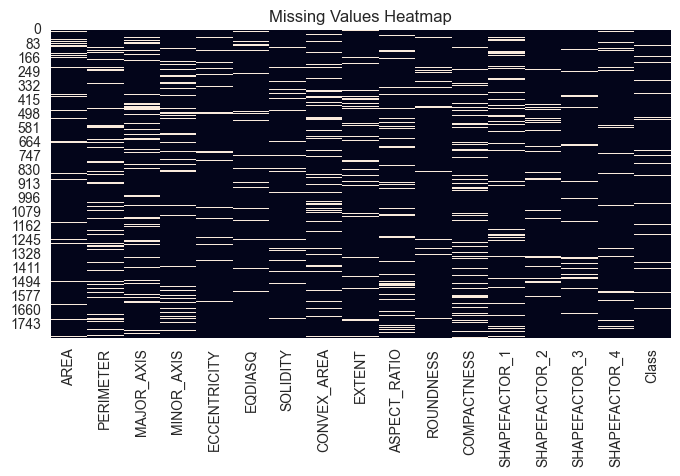

AREA             155
PERIMETER        265
MAJOR_AXIS       225
MINOR_AXIS       205
ECCENTRICITY     110
EQDIASQ          110
SOLIDITY          95
CONVEX_AREA      233
EXTENT           193
ASPECT_RATIO     243
ROUNDNESS         94
COMPACTNESS      282
SHAPEFACTOR_1    237
SHAPEFACTOR_2    115
SHAPEFACTOR_3    118
SHAPEFACTOR_4    126
Class            136
dtype: int64

In [4]:
plt.figure(figsize=(8,4))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

train.isnull().sum()


## Target Identification

In [5]:
target_col = train.columns[-1]
train = train[train[target_col].notna()]
X = train.drop(columns=[target_col])
y = train[target_col]

print("Target column:", target_col)
print("Target classes:", y.unique())


Target column: Class
Target classes: ['Kirmizi_Pistachio' 'Siit_Pistachio']


## Target Distribution

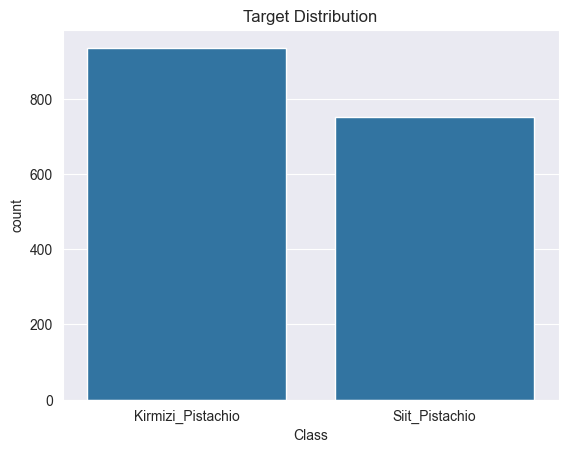

In [6]:

sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()


## Feature Type Detection

## Numerical Feature Distributions

In [7]:
# X_train, X_val, y_train, y_val = train_test_split(
#     X,
#     y_encoded,
#     test_size=0.2,
#     stratify=y_encoded,
#     random_state=42
# )
X_train,X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [8]:

num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(exclude=np.number).columns

print("Numerical Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))


Numerical Columns: ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'SHAPEFACTOR_4']
Categorical Columns: []


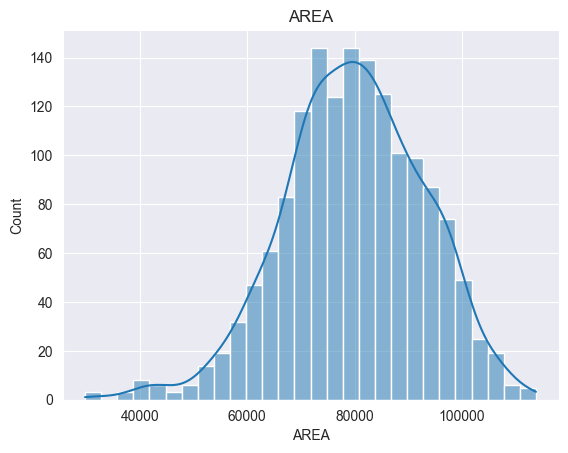

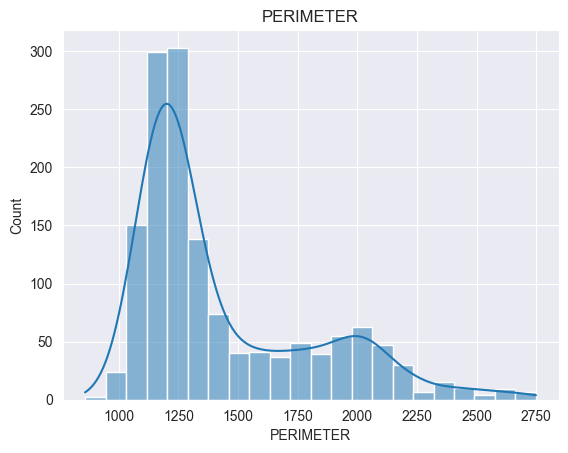

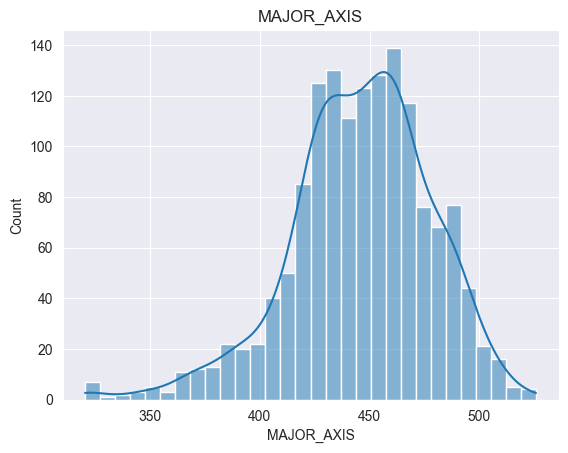

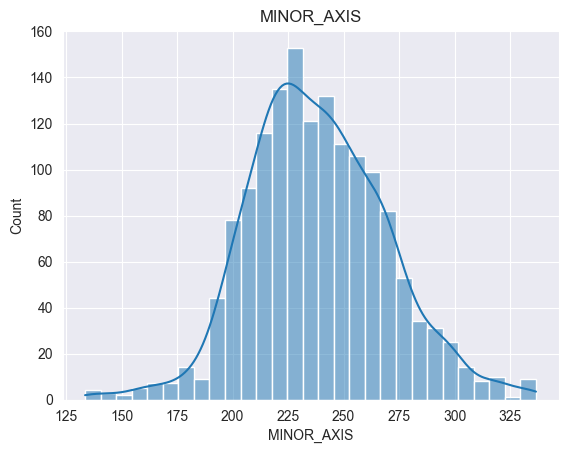

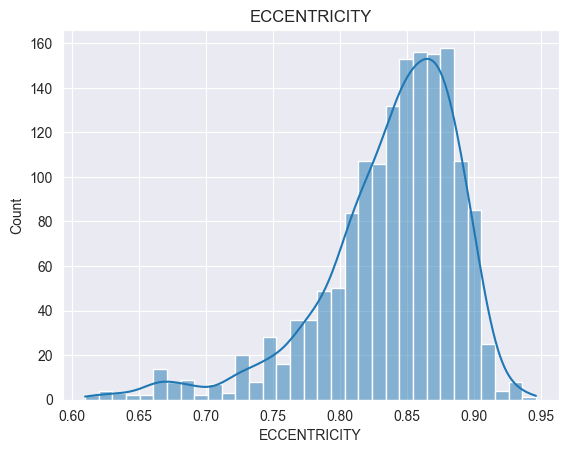

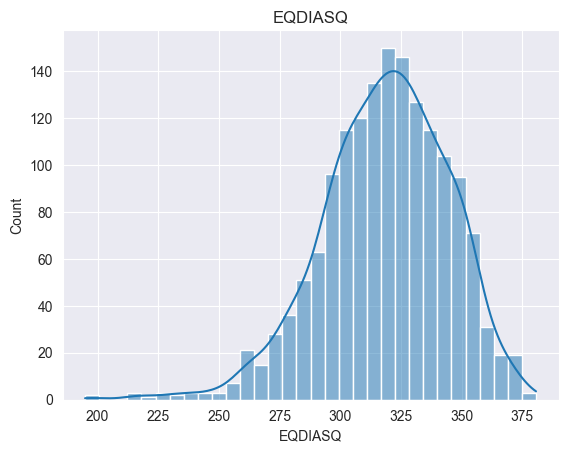

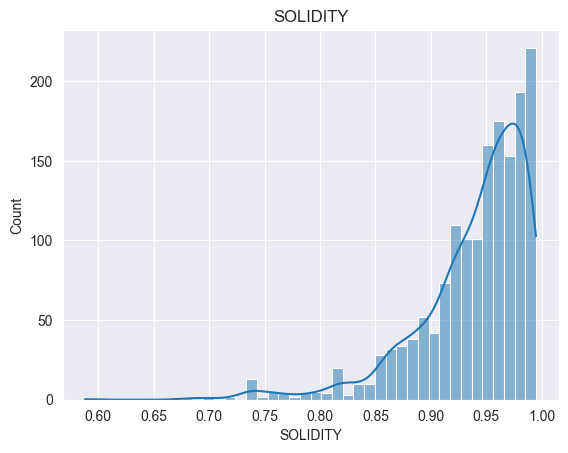

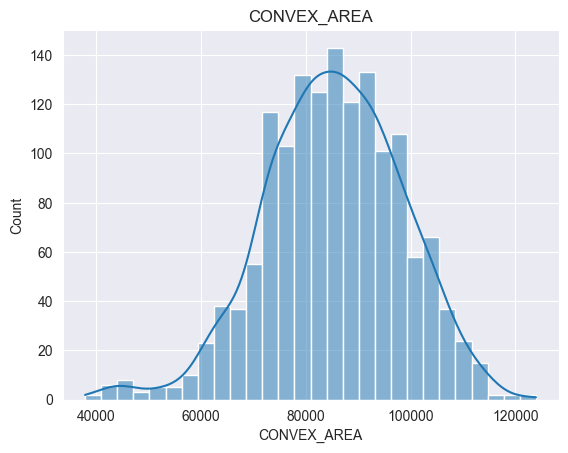

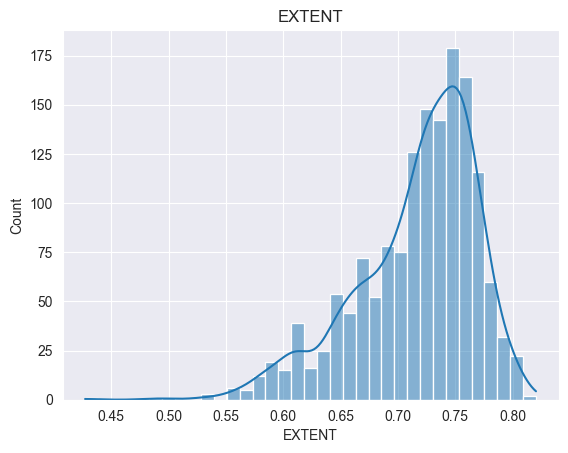

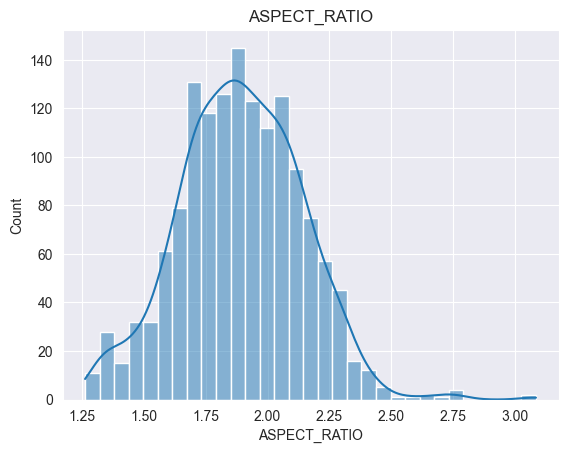

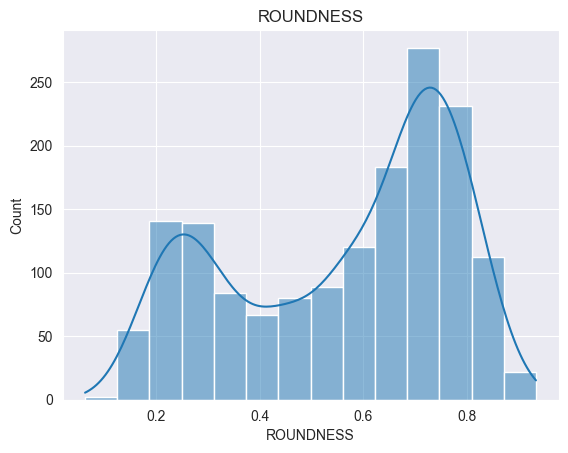

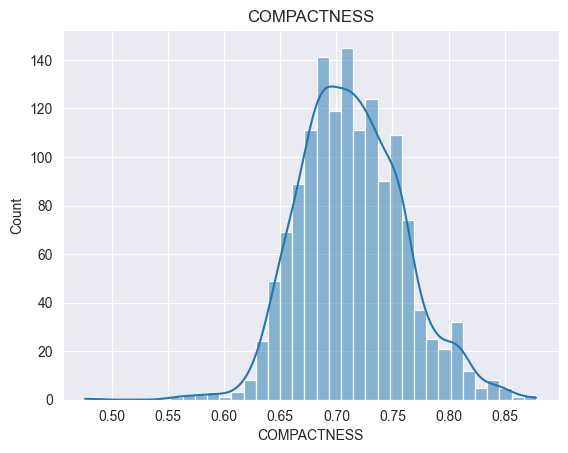

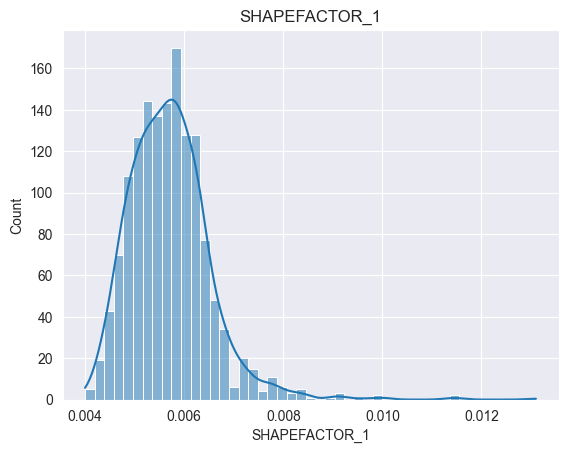

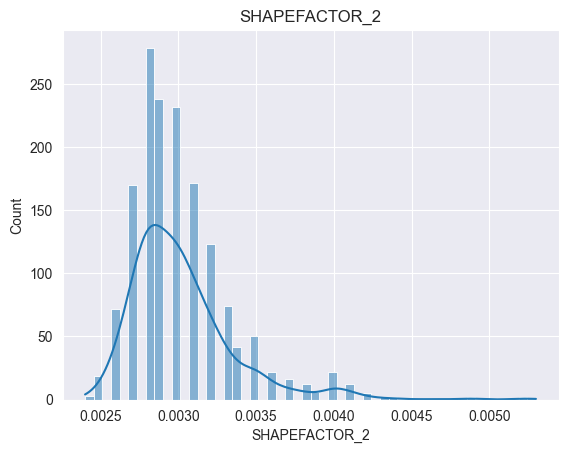

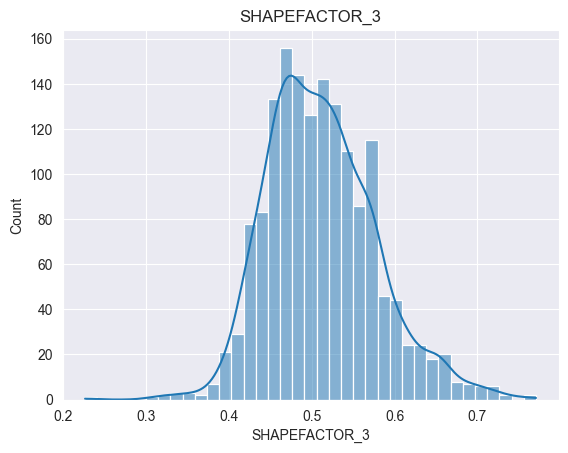

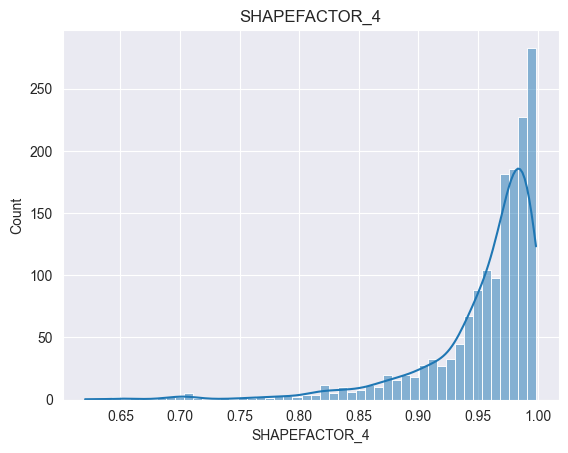

In [9]:

for col in num_cols:
    sns.histplot(X[col], kde=True)
    plt.title(col)
    plt.show()


## Boxplots (Outlier Detection)

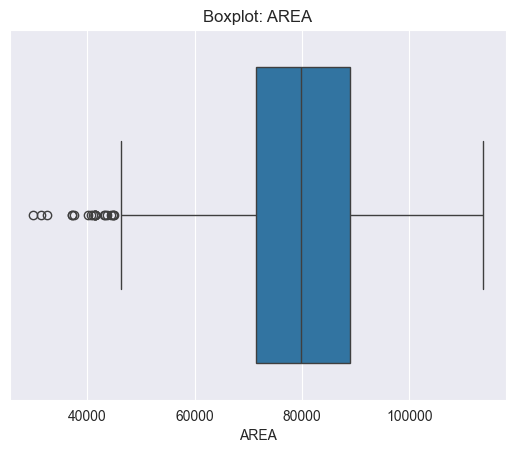

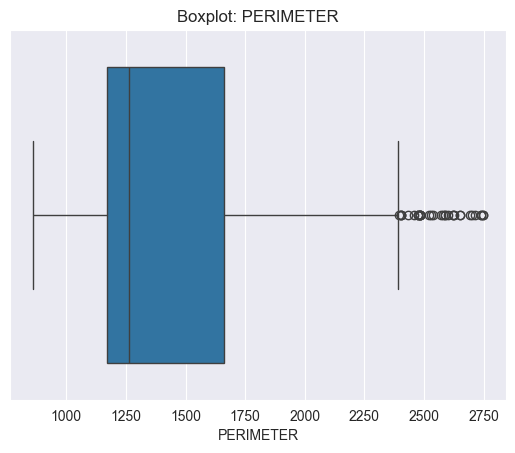

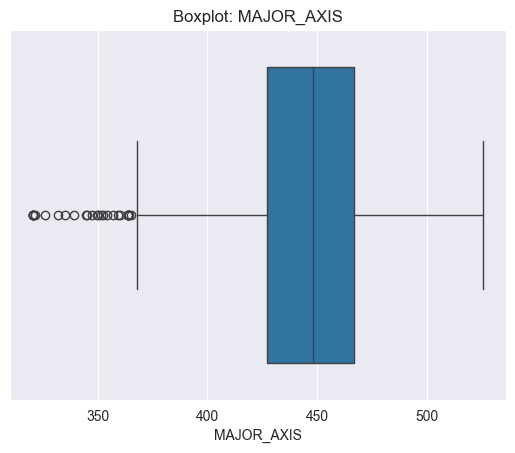

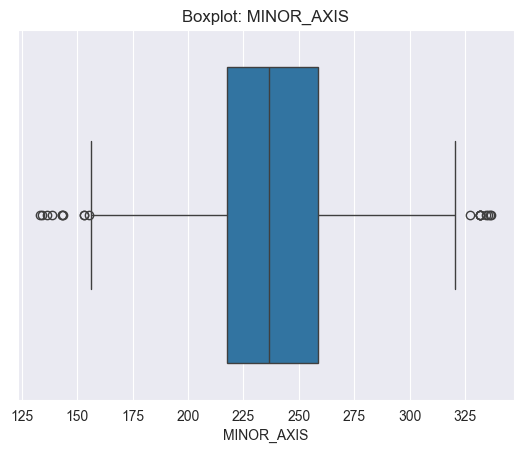

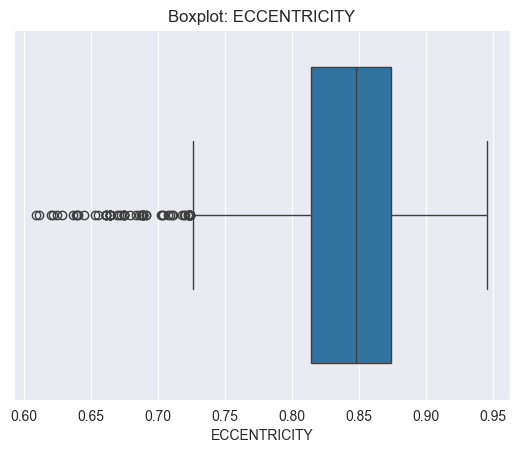

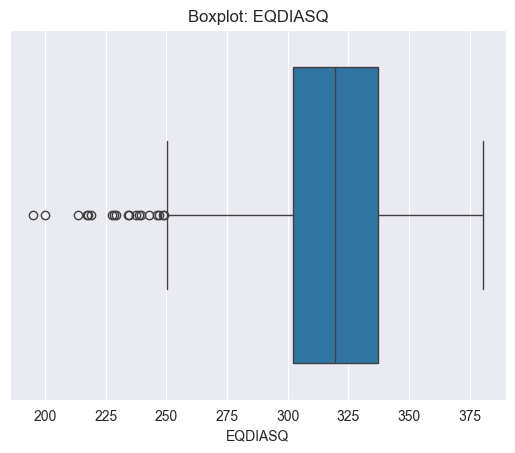

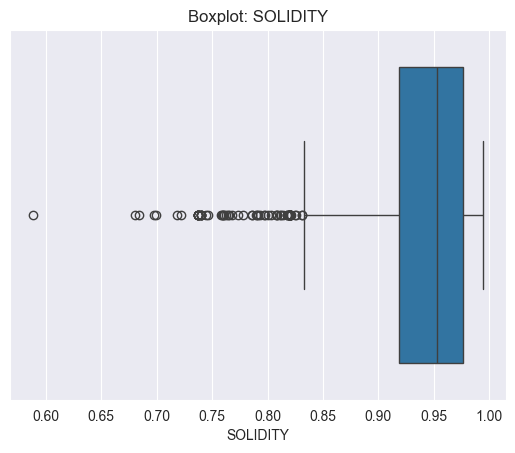

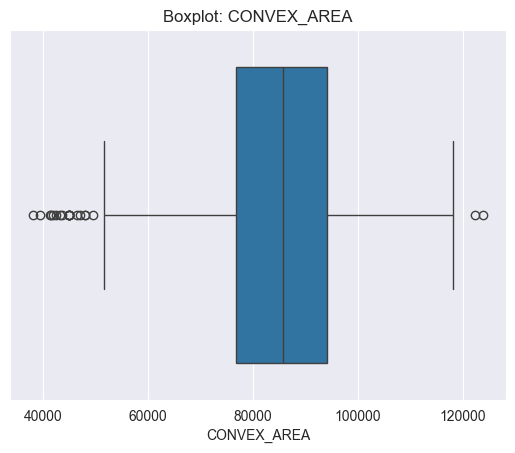

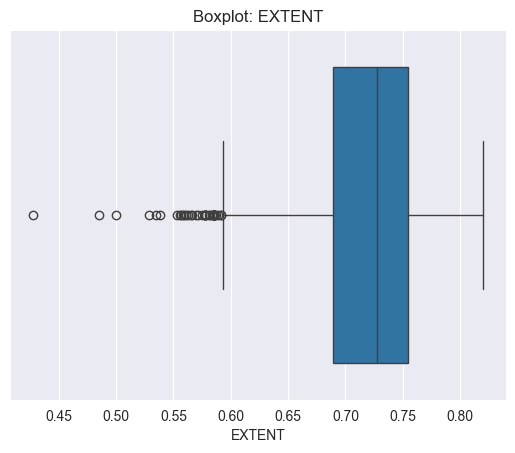

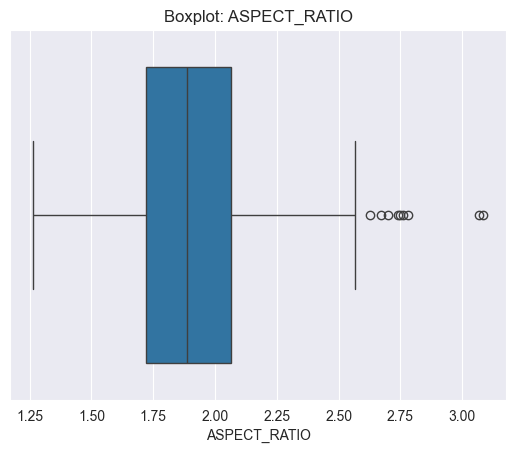

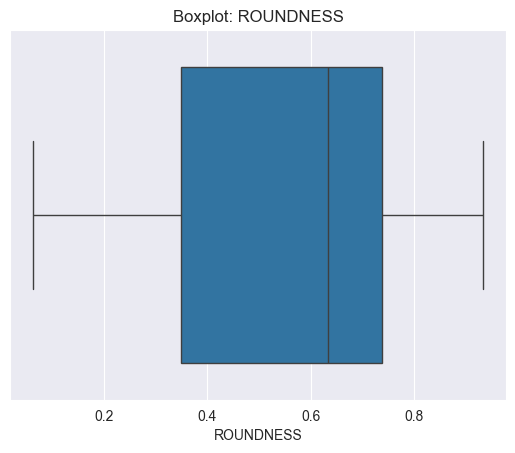

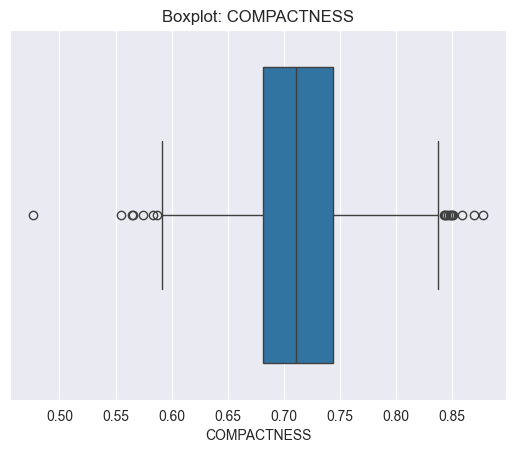

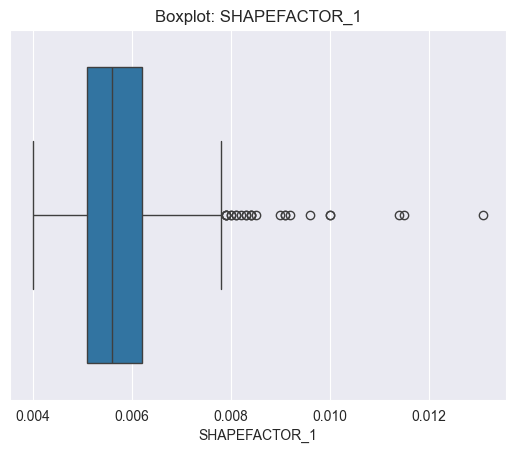

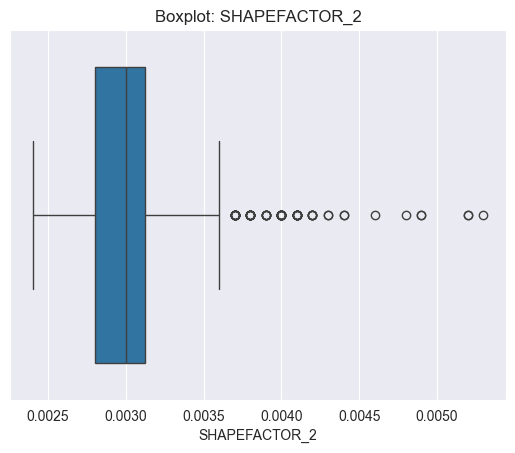

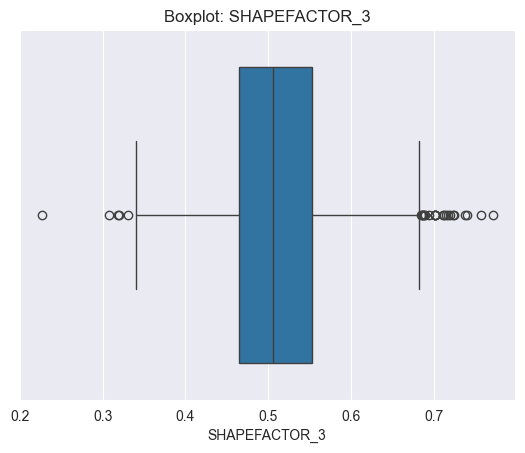

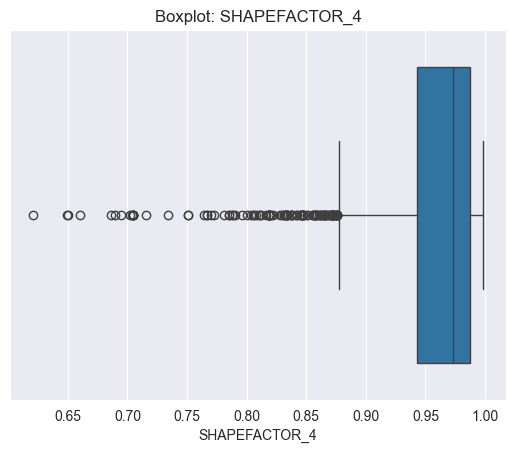

In [10]:

for col in num_cols:
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot: {col}")
    plt.show()


## Missing Value Handling

In [11]:
for col in num_cols:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)
    X_val[col].fillna(median, inplace=True)
    test[col].fillna(median, inplace=True)

# Categorical → Mode
for col in cat_cols:
    mode = X_train[col].mode()[0]
    X_train[col].fillna(mode, inplace=True)
    X_val[col].fillna(mode, inplace=True)
    test[col].fillna(mode, inplace=True)



## Encode Categorical Features

In [12]:
# for col in cat_cols:
#      le = LabelEncoder()
#      X[col] = le.fit_transform(X[col])
#      test[col] = le.transform(test[col])


label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

    # Handle unseen labels
    X_val[col] = X_val[col].map(
        lambda x: x if x in le.classes_ else le.classes_[0]
    )
    test[col] = test[col].map(
        lambda x: x if x in le.classes_ else le.classes_[0]
    )

    X_val[col] = le.transform(X_val[col])
    test[col] = le.transform(test[col])

    label_encoders[col] = le

## Outlier Handling (IQR – Conditional)

In [13]:
for col in num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    X[col] = np.clip(X[col], lower, upper)


## Label Encoding Target

In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Encoded classes:", label_encoder.classes_)




Encoded classes: ['Kirmizi_Pistachio' 'Siit_Pistachio']


## Imbalance Detection

In [15]:
class_counts = np.bincount(y_encoded)
class_ratios = class_counts / class_counts.sum()

imbalance_ratio = class_ratios.min() / class_ratios.max()
use_class_weight = imbalance_ratio < 0.5

print("Class ratios:", class_ratios)
print("Imbalanced:", use_class_weight)


Class ratios: [0.55450237 0.44549763]
Imbalanced: False


## Train / Validation Split

## Define Models

In [16]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    class_weight="balanced" if use_class_weight else None,
    random_state=42
)

bag = BaggingClassifier(
    estimator=rf,
    n_estimators=10,
    random_state=42
)

boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

models = {
    "Random Forest": rf,
    "Bagging": bag,
    "Boosting": boost
}




## Full Evaluation

In [17]:
AVG = "macro"  # universal choice

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    results.append([
        name,
        accuracy_score(y_val, val_pred),
        precision_score(y_val, val_pred, average=AVG),
        recall_score(y_val, val_pred, average=AVG),
        f1_score(y_val, val_pred, average=AVG),
        f1_score(y_train, tr_pred, average=AVG) -
        f1_score(y_val, val_pred, average=AVG)
    ])

results_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Val Acc",
        "Precision",
        "Recall",
        "F1",
        "Overfit Gap"
    ]
)

results_df


,Model,Val Acc,Precision,Recall,F1,Overfit Gap
0,Random Forest,0.902367,0.901068,0.901565,0.901309,0.037150
1,Bagging,0.905325,0.903904,0.904877,0.904358,0.008700
2,Boosting,0.884615,0.884489,0.881698,0.882892,0.011693


## Automatic Model Selection

In [18]:
safe_models = results_df[results_df["Overfit Gap"] <= 0.05]

best_model_name = safe_models.sort_values(
    ["F1", "Val Acc"],
    ascending=False
).iloc[0]["Model"]

final_model = models[best_model_name]

print("Selected model:", best_model_name)


Selected model: Bagging


## Final Evaluation

                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.92      0.91      0.91       187
   Siit_Pistachio       0.89      0.90      0.89       151

         accuracy                           0.91       338
        macro avg       0.90      0.90      0.90       338
     weighted avg       0.91      0.91      0.91       338



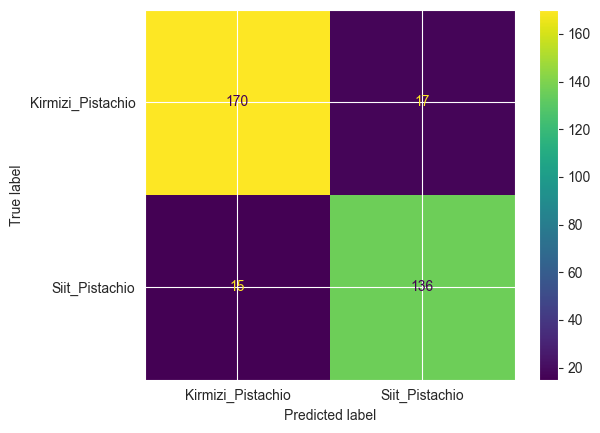

In [19]:
final_model.fit(X_train, y_train)
val_pred = final_model.predict(X_val)

print(classification_report(y_val, val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, val_pred)
plt.show()


## ROC-AUC

In [20]:
is_binary = len(np.unique(y_encoded)) == 2

if is_binary:
    roc_auc = roc_auc_score(
        y_val,
        final_model.predict_proba(X_val)[:, 1]
    )
    print("ROC–AUC:", roc_auc)
else:
    roc_auc = roc_auc_score(
        y_val,
        final_model.predict_proba(X_val),
        multi_class="ovr",
        average="macro"
    )
    print("Multiclass ROC–AUC:", roc_auc)


ROC–AUC: 0.967135318907816


## Train Final Model & Predict Test

In [21]:
final_model.fit(X, y_encoded)

test_preds = label_encoder.inverse_transform(
    final_model.predict(test)
)
# test_preds=final_model.predict(test)


## Create submission.csv

In [22]:
submission = pd.DataFrame({
    "id": test_ids,
    target_col: test_preds
})

submission.to_csv("submission.csv", index=False)
submission.isnull().values.any()
submission.isnull().sum()

submission.head()


,id,Class
0,1,Kirmizi_Pistachio
1,2,Siit_Pistachio
2,3,Kirmizi_Pistachio
3,4,Kirmizi_Pistachio
4,5,Kirmizi_Pistachio


## ✅ End – Upload submission.csv to Kaggle